In [ ]:
!pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

In [ ]:
# import ktrain
import pandas as pd
df = pd.DataFrame(columns=["Label","Posts"])

In [ ]:
chunksize = 5000
for chunk in pd.read_csv("/content/drive/MyDrive/Thesis Papers/SMHD/final_cleaned_data.csv", chunksize=chunksize):
  df=df.append(chunk,ignore_index=True)

In [ ]:
df["Label"].value_counts()

control          15202
depression       14139
bipolar           6434
ptsd              2894
schizophrenia     1331
Name: Label, dtype: int64

In [ ]:
df_c = df[df["Label"] == "control"]
df_d = df[df["Label"] == "depression"]

df_c = df_c.sample(frac = 1)
df_c = df_c.sample(frac = 1).iloc[0:3000,]

df_d = df_d.sample(frac = 1)
df_d = df_d.sample(frac = 1).iloc[0:3000,]

# df_c = df_c.iloc[0:5000,]
# df_d = df_d.iloc[0:5000,] 

In [ ]:
def stripstr(x):
  return len(x.strip())==0

In [ ]:
result = pd.concat([df_c, df_d], ignore_index=True, sort=False)
empty = result[result["Posts"].apply(stripstr)]
indexarr = empty.index
result.drop(index = indexarr, inplace=True)

In [ ]:
result.describe()

,Label,Posts
count,5979,5979
unique,2,5979
top,depression,yay for the aberystwyth university charity mon...
freq,3000,1


In [ ]:
result = result.sample(frac = 1)

In [ ]:
import re
import pandas as pd

import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def tokenize(txt):
  tokens = re.split('\W+',txt) # W means non-word characters and + means one or more
  return tokens

def lemmed(txt):
  text = [wn.lemmatize(word) for word in txt]
  return text

def remove_stopwords(txt):
  clean_msg = [word for word in txt if word not in stopwords]
  return clean_msg

In [ ]:
result['Posts'] = result['Posts'].apply(lambda x: tokenize(x))
result['Posts'] = result['Posts'].apply(remove_stopwords)
result['Posts'] = result['Posts'].apply(lemmed)
result["Posts"]=result["Posts"].apply(lambda x: " ".join(x))

In [ ]:
del(df_c)
del(df_d)
del(df)

In [ ]:
x=result["Posts"]
y=result["Label"]

In [ ]:
y

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

# ML Model

In [ ]:
from ktrain import text

In [ ]:
model_name = "distilbert-base-uncased"
trans = text.Transformer(model_name, maxlen = 512)#class_names=["control", "schizophrenia"]

In [ ]:
train_data = trans.preprocess_train(x_train.tolist(), y_train.tolist())
test_data = trans.preprocess_test(x_test.tolist(), y_test.tolist())

preprocessing train...
language: en
train sequence lengths:
	mean : 5746
	95percentile : 17405
	99percentile : 30932


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 5556
	95percentile : 16902
	99percentile : 28782


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=test_data, batch_size=16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
261/261 [==============================] - 250s 920ms/step - loss: 0.6899 - accuracy: 0.5184
Epoch 2/4
261/261 [==============================] - 258s 990ms/step - loss: 0.6429 - accuracy: 0.6385
Epoch 3/4
261/261 [==============================] - 248s 948ms/step - loss: 0.7790 - accuracy: 0.4898
Epoch 4/4
261/261 [==============================] - 45s 171ms/step - loss: 1127.3357 - accuracy: 0.4868


done.
Visually inspect loss plot and select learning rate associated with falling loss


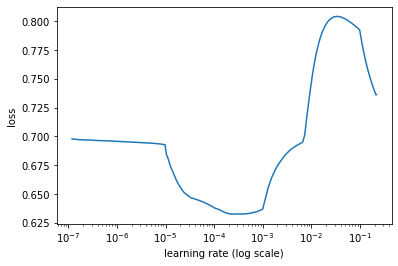

In [ ]:
learner.lr_find(show_plot=True, max_epochs=4, suggest=True)

In [ ]:
learner.fit_onecycle(1e-4,3)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/3
262/262 [==============================] - 302s 1s/step - loss: 0.6372 - accuracy: 0.6282 - val_loss: 0.5670 - val_accuracy: 0.7023
Epoch 2/3
262/262 [==============================] - 299s 1s/step - loss: 0.5435 - accuracy: 0.7357 - val_loss: 0.5528 - val_accuracy: 0.7157
Epoch 3/3
262/262 [==============================] - 299s 1s/step - loss: 0.3528 - accuracy: 0.8581 - val_loss: 0.5975 - val_accuracy: 0.7241


In [ ]:
learner.validate(class_names=["control","depression"])

              precision    recall  f1-score   support

     control       0.74      0.67      0.70       881
  depression       0.71      0.78      0.74       913

    accuracy                           0.72      1794
   macro avg       0.73      0.72      0.72      1794
weighted avg       0.73      0.72      0.72      1794



array([[590, 291],
       [204, 709]])

In [ ]:
learner.view_top_losses(n=8, preproc=trans)

In [ ]:
x_test.loc[39]

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
xstr = "boy i'm very sad and hungry. I don't know what to do. i really miss her so much."

In [ ]:
predictor.predict(xstr)

'depression'